## 1. Import Libraries

We need PyTorch for training neural networks and the Segmentation Models library which provides pretrained U-Net architectures.

In [5]:

import sys

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

root = Path().resolve().parents[0]
sys.path.append(str(root))

from src.config import VHR_DIR, MASK_DIR
from src.data.simple_habloss_dataset import SimpleHablossPatchDataset

## 2. Setup Device

Check if we have a GPU available. Training on GPU is apparently much faster than CPU.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Create Datasets and Data Loaders


**Training dataset:**
- Uses 20 patches per image
- Has data augmentation turned on (random flips, rotations to make model more robust)

**Validation dataset:**
- Uses 10 patches per image  
- No augmentation (want consistent results to measure performance)

In [9]:
mean = None
std = None

train_ds = SimpleHablossPatchDataset(VHR_DIR, MASK_DIR, patch_size=128,
                                     patches_per_image=20, mean=mean, std=std, augment=True)
val_ds   = SimpleHablossPatchDataset(VHR_DIR, MASK_DIR, patch_size=128,
                                     patches_per_image=10, mean=mean, std=std, augment=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print(f"Training patches: {len(train_ds)}")
print(f"Validation patches: {len(val_ds)}")

Training patches: 120
Validation patches: 60


## 4. Build the U-Net Model


In [10]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    classes=2
).to(device)

print(f"Model created and moved to {device}")

Model created and moved to cpu


## 5. Setup Loss Function and Optimizer

**Loss function (CrossEntropyLoss):** Measures how wrong the model's predictions are. Lower is better.

**Optimizer (Adam):** Updates the model weights to reduce the loss. Learning rate controls how big the update steps are.n

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 6. Define Training Function

This function processes one epoch (one pass through all the data). It can run in training mode or evaluation mode:

- **Training mode:** The model learns from the data and updates its weights
- **Evaluation mode:** The model makes predictions but doesn't learn (for validation)

The function returns the average loss and accuracy for the epoch.

In [12]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        with torch.set_grad_enabled(train):
            logits = model(imgs)
            loss = loss_fn(logits, masks)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        total_correct += (preds == masks).sum().item()
        total_pixels  += masks.numel()

    avg_loss = total_loss / len(loader.dataset)
    acc = 100.0 * total_correct / total_pixels
    return avg_loss, acc

## 7. Train the Model

Run the training loop for 10 epochs. Each epoch:
1. Trains on all training data
2. Validates on all validation data
3. Prints the results


In [15]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(10):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc     = run_epoch(val_loader, train=False)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}: "
          f"Train loss {train_loss:.3f}, acc {train_acc:.1f}% | "
          f"Val loss {val_loss:.3f}, acc {val_acc:.1f}%")

Epoch 1: Train loss 0.302, acc 87.2% | Val loss 0.484, acc 83.3%
Epoch 2: Train loss 0.298, acc 87.8% | Val loss 0.263, acc 89.6%
Epoch 2: Train loss 0.298, acc 87.8% | Val loss 0.263, acc 89.6%
Epoch 3: Train loss 0.353, acc 84.8% | Val loss 0.268, acc 89.8%
Epoch 3: Train loss 0.353, acc 84.8% | Val loss 0.268, acc 89.8%
Epoch 4: Train loss 0.276, acc 88.3% | Val loss 0.429, acc 81.7%
Epoch 4: Train loss 0.276, acc 88.3% | Val loss 0.429, acc 81.7%
Epoch 5: Train loss 0.328, acc 86.5% | Val loss 0.283, acc 89.9%
Epoch 5: Train loss 0.328, acc 86.5% | Val loss 0.283, acc 89.9%
Epoch 6: Train loss 0.256, acc 90.0% | Val loss 0.325, acc 91.3%
Epoch 6: Train loss 0.256, acc 90.0% | Val loss 0.325, acc 91.3%
Epoch 7: Train loss 0.235, acc 90.5% | Val loss 0.437, acc 88.5%
Epoch 7: Train loss 0.235, acc 90.5% | Val loss 0.437, acc 88.5%
Epoch 8: Train loss 0.217, acc 91.5% | Val loss 0.319, acc 85.3%
Epoch 8: Train loss 0.217, acc 91.5% | Val loss 0.319, acc 85.3%
Epoch 9: Train loss 0.318

## 8. Visualize Training Progress

Plot the loss and accuracy curves to see how the model improved over time.

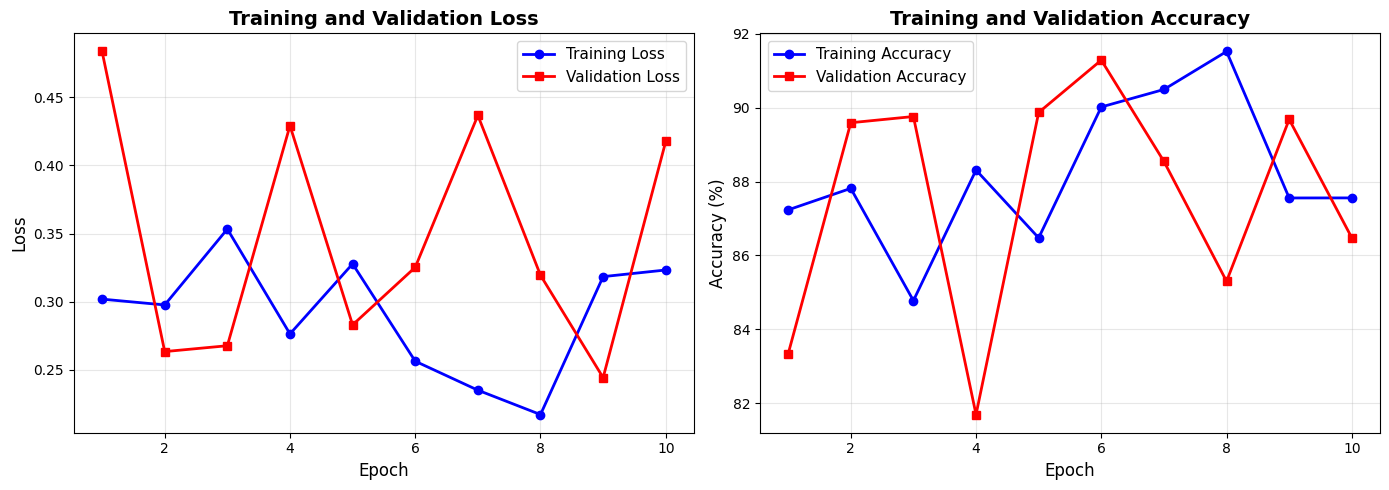


Final Results:
Training   - Loss: 0.323, Accuracy: 87.6%
Validation - Loss: 0.418, Accuracy: 86.5%


In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(train_losses) + 1)

ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
ax1.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, train_accs, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
ax2.plot(epochs, val_accs, 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Training   - Loss: {train_losses[-1]:.3f}, Accuracy: {train_accs[-1]:.1f}%")
print(f"Validation - Loss: {val_losses[-1]:.3f}, Accuracy: {val_accs[-1]:.1f}%")